# Import package

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import loggers
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
%load_ext autoreload
%autoreload 2

# Setup environment

In [5]:
device = "cuda" if torch.cuda.is_available else "cpu"

def format_bytes(size):
    # 2**10 = 1024
    power = 2**10
    n = 0
    power_labels = {0 : '', 1: 'kilo', 2: 'mega', 3: 'giga', 4: 'tera'}
    while size > power:
        size /= power
        n += 1
    return "%.2f" % size, power_labels[n] + 'bytes'

torch.cuda.get_device_name(), format_bytes(torch.cuda.get_device_properties(device).total_memory)

('GeForce GTX 1080 Ti', ('10.92', 'gigabytes'))

In [6]:
from preprocessing.train_test_split import load_by_institution
from preprocessing.augment.get_transform import get_transform
table = load_by_institution(["standard_transforms", None], os.path.join(os.getcwd(), "data", "train12x128x128"), "crossentropy")

In [7]:
table

{'karolinska': {'trainset': <preprocessing.load_dataset.PandaDataset at 0x7f3764f44cd0>,
  'valset': <preprocessing.load_dataset.PandaDataset at 0x7f36cec21c40>},
 'radboud': {'trainset': <preprocessing.load_dataset.PandaDataset at 0x7f36cec21d90>,
  'valset': <preprocessing.load_dataset.PandaDataset at 0x7f36cec21f70>}}

# Load model for karolinska

In [8]:
dataset = table["karolinska"]

In [9]:
from preprocessing.load_dataset import PandaDataset

In [10]:
from trainer.distill.teacher import TeacherBaselineTrainer
model = TeacherBaselineTrainer("karolinska", dataset["trainset"], dataset["valset"])
max_epoches = model.get_max_epoches()

>> Assign exist data frame


Using cache found in /home/kientiet/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


In [11]:
checkpoint_path = os.path.join(os.getcwd(), "checkpoint", model.model_name, "karolinska")
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_top_k = 5,
    verbose = True,
    monitor = 'kappa_score',
    mode = 'max'
)

checkpoint_path

/home/kientiet/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Checkpoint directory /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/karolinska exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)


'/home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/karolinska'

In [12]:
tb_logger = loggers.TensorBoardLogger('logs/', name = model.model_name)
trainer = pl.Trainer(checkpoint_callback = checkpoint_callback,
                    nb_sanity_val_steps = 0, 
                    max_epochs = max_epoches, 
                    gpus = -1, 
                    logger = tb_logger)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


# Learning finder

In [31]:
lr_finder = trainer.lr_find(model, min_lr = 1e-8, max_lr = 5., num_training = 200)

INFO:lightning:
   | Name                             | Type              | Params
-------------------------------------------------------------------
0  | loss_func                        | CrossEntropyLoss  | 0     
1  | encoder                          | ResNetModel       | 11 M  
2  | encoder.encoder                  | Sequential        | 11 M  
3  | encoder.encoder.0                | Conv2d            | 9 K   
4  | encoder.encoder.1                | BatchNorm2d       | 128   
5  | encoder.encoder.2                | ReLU              | 0     
6  | encoder.encoder.3                | MaxPool2d         | 0     
7  | encoder.encoder.4                | Sequential        | 147 K 
8  | encoder.encoder.4.0              | BasicBlock        | 73 K  
9  | encoder.encoder.4.0.conv1        | Conv2d            | 36 K  
10 | encoder.encoder.4.0.bn1          | BatchNorm2d       | 128   
11 | encoder.encoder.4.0.relu         | ReLU              | 0     
12 | encoder.encoder.4.0.conv2        | Conv2

INFO:lightning:Detected KeyboardInterrupt, attempting graceful shutdown...
INFO:lightning:LR finder stopped early due to diverging loss.


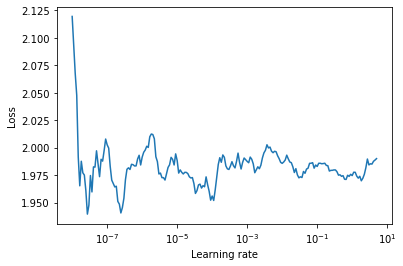

In [12]:
fig = lr_finder.plot(suggest = True)

In [13]:
model.max_lr = 2e-3
model.current_epoch = 0
model.configure_optimizers()

SGD (
Parameter Group 0
    base_momentum: 0.85
    dampening: 0
    initial_lr: 8e-05
    lr: 0.001999946624130242
    max_lr: 0.002
    max_momentum: 0.9
    min_lr: 8.000000000000001e-07
    momentum: 0.8500013349307162
    nesterov: False
    weight_decay: 5e-05
)

## Start to train

In [14]:
trainer.fit(model)

INFO:lightning:
    | Name                             | Type              | Params
-------------------------------------------------------------------
0   | loss_func                        | CrossEntropyLoss  | 0     
1   | encoder                          | ResNetModel       | 22 M  
2   | encoder.encoder                  | Sequential        | 22 M  
3   | encoder.encoder.0                | Conv2d            | 9 K   
4   | encoder.encoder.1                | BatchNorm2d       | 128   
5   | encoder.encoder.2                | ReLU              | 0     
6   | encoder.encoder.3                | MaxPool2d         | 0     
7   | encoder.encoder.4                | Sequential        | 205 K 
8   | encoder.encoder.4.0              | Bottleneck        | 63 K  
9   | encoder.encoder.4.0.conv1        | Conv2d            | 8 K   
10  | encoder.encoder.4.0.bn1          | BatchNorm2d       | 256   
11  | encoder.encoder.4.0.conv2        | Conv2d            | 4 K   
12  | encoder.encoder.4.0.bn2   

INFO:lightning:
Epoch 00000: kappa_score reached 0.34963 (best 0.34963), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/karolinska/epoch=0.ckpt as top 5


INFO:lightning:
Epoch 00001: kappa_score reached 0.33486 (best 0.34963), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/karolinska/epoch=1_v0.ckpt as top 5


INFO:lightning:
Epoch 00002: kappa_score reached 0.53323 (best 0.53323), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/karolinska/epoch=2_v1.ckpt as top 5


INFO:lightning:
Epoch 00003: kappa_score reached 0.56445 (best 0.56445), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/karolinska/epoch=3_v2.ckpt as top 5


INFO:lightning:
Epoch 00004: kappa_score reached 0.44509 (best 0.56445), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/karolinska/epoch=4_v1.ckpt as top 5


INFO:lightning:
Epoch 00005: kappa_score reached 0.43340 (best 0.56445), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/karolinska/epoch=5_v0.ckpt as top 5


INFO:lightning:
Epoch 00006: kappa_score reached 0.57471 (best 0.57471), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/karolinska/epoch=6_v0.ckpt as top 5


INFO:lightning:
Epoch 00007: kappa_score reached 0.53943 (best 0.57471), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/karolinska/epoch=7_v0.ckpt as top 5


INFO:lightning:
Epoch 00008: kappa_score reached 0.55287 (best 0.57471), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/karolinska/epoch=8.ckpt as top 5


INFO:lightning:
Epoch 00009: kappa_score reached 0.65272 (best 0.65272), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/karolinska/epoch=9_v0.ckpt as top 5


INFO:lightning:
Epoch 00010: kappa_score reached 0.61841 (best 0.65272), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/karolinska/epoch=10_v1.ckpt as top 5


INFO:lightning:
Epoch 00011: kappa_score reached 0.62271 (best 0.65272), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/karolinska/epoch=11_v0.ckpt as top 5


1

# Load model for Radboud

In [15]:
dataset = table["radboud"]

In [16]:
from preprocessing.load_dataset import PandaDataset

In [20]:
from trainer.distill.teacher import TeacherTrainer
model = TeacherTrainer("radboud", dataset["trainset"], dataset["valset"])
max_epoches = model.get_max_epoches()

>> Assign exist data frame


Using cache found in /home/kientiet/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


In [21]:
checkpoint_path = os.path.join(os.getcwd(), "checkpoint", model.model_name, "radboud")
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_top_k = 5,
    verbose = True,
    monitor = 'kappa_score',
    mode = 'max'
)

checkpoint_path

'/home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/radboud'

In [22]:
tb_logger = loggers.TensorBoardLogger('logs/', name = model.model_name)
trainer = pl.Trainer(checkpoint_callback = checkpoint_callback,
                    nb_sanity_val_steps = 0, 
                    max_epochs = max_epoches, 
                    gpus = -1, 
                    logger = tb_logger)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


# Learning finder

In [8]:
lr_finder = trainer.lr_find(model, min_lr = 1e-8, max_lr = 5., num_training = 200)

INFO:lightning:
    | Name                             | Type              | Params
-------------------------------------------------------------------
0   | loss_func                        | BCELoss           | 0     
1   | encoder                          | ResNetModel       | 22 M  
2   | encoder.encoder                  | Sequential        | 22 M  
3   | encoder.encoder.0                | Conv2d            | 9 K   
4   | encoder.encoder.1                | BatchNorm2d       | 128   
5   | encoder.encoder.2                | ReLU              | 0     
6   | encoder.encoder.3                | MaxPool2d         | 0     
7   | encoder.encoder.4                | Sequential        | 205 K 
8   | encoder.encoder.4.0              | Bottleneck        | 63 K  
9   | encoder.encoder.4.0.conv1        | Conv2d            | 8 K   
10  | encoder.encoder.4.0.bn1          | BatchNorm2d       | 256   
11  | encoder.encoder.4.0.conv2        | Conv2d            | 4 K   
12  | encoder.encoder.4.0.bn2   

> /home/kientiet/Documents/My Project/python/panda-kaggle/trainer/supervised/baseline.py(28)forward()
-> batch_size, image_batch, channels, height, width = images.shape


(Pdb)  n


> /home/kientiet/Documents/My Project/python/panda-kaggle/trainer/supervised/baseline.py(29)forward()
-> images = images.reshape(-1, channels, height, width)


(Pdb)  n


> /home/kientiet/Documents/My Project/python/panda-kaggle/trainer/supervised/baseline.py(32)forward()
-> logits = self.encoder(images)


(Pdb)  n


> /home/kientiet/Documents/My Project/python/panda-kaggle/trainer/supervised/baseline.py(33)forward()
-> shape = logits.shape


(Pdb)  n


> /home/kientiet/Documents/My Project/python/panda-kaggle/trainer/supervised/baseline.py(35)forward()
-> logits = logits.view(-1, image_batch, shape[1], shape[2], shape[3]).permute(0, 2, 1, 3, 4).contiguous() \


(Pdb)  n


> /home/kientiet/Documents/My Project/python/panda-kaggle/trainer/supervised/baseline.py(36)forward()
-> .view(-1, shape[1], shape[2] * image_batch, shape[3])


(Pdb)  n


> /home/kientiet/Documents/My Project/python/panda-kaggle/trainer/supervised/baseline.py(35)forward()
-> logits = logits.view(-1, image_batch, shape[1], shape[2], shape[3]).permute(0, 2, 1, 3, 4).contiguous() \


(Pdb)  n


> /home/kientiet/Documents/My Project/python/panda-kaggle/trainer/supervised/baseline.py(37)forward()
-> logits = self.project_layer(logits)


(Pdb)  n


> /home/kientiet/Documents/My Project/python/panda-kaggle/trainer/supervised/baseline.py(38)forward()
-> logits = torch.sigmoid(logits)


(Pdb)  logits.shape


torch.Size([16, 5])


(Pdb)  exit


BdbQuit: 

In [ ]:
fig = lr_finder.plot(suggest = True)

In [23]:
model.max_lr = 2e-3
model.current_epoch = 0
model.configure_optimizers()

SGD (
Parameter Group 0
    base_momentum: 0.85
    dampening: 0
    initial_lr: 8e-05
    lr: 0.0019999964271070416
    max_lr: 0.002
    max_momentum: 0.9
    min_lr: 8.000000000000001e-07
    momentum: 0.8500000893580671
    nesterov: False
    weight_decay: 5e-05
)

## Start to train

In [24]:
trainer.fit(model)

INFO:lightning:
    | Name                             | Type              | Params
-------------------------------------------------------------------
0   | loss_func                        | CrossEntropyLoss  | 0     
1   | encoder                          | ResNetModel       | 22 M  
2   | encoder.encoder                  | Sequential        | 22 M  
3   | encoder.encoder.0                | Conv2d            | 9 K   
4   | encoder.encoder.1                | BatchNorm2d       | 128   
5   | encoder.encoder.2                | ReLU              | 0     
6   | encoder.encoder.3                | MaxPool2d         | 0     
7   | encoder.encoder.4                | Sequential        | 205 K 
8   | encoder.encoder.4.0              | Bottleneck        | 63 K  
9   | encoder.encoder.4.0.conv1        | Conv2d            | 8 K   
10  | encoder.encoder.4.0.bn1          | BatchNorm2d       | 256   
11  | encoder.encoder.4.0.conv2        | Conv2d            | 4 K   
12  | encoder.encoder.4.0.bn2   

INFO:lightning:
Epoch 00000: kappa_score reached 0.39015 (best 0.39015), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/radboud/epoch=0.ckpt as top 5


INFO:lightning:
Epoch 00001: kappa_score reached 0.46261 (best 0.46261), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/radboud/epoch=1.ckpt as top 5


INFO:lightning:
Epoch 00002: kappa_score reached 0.55021 (best 0.55021), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/radboud/epoch=2.ckpt as top 5


INFO:lightning:
Epoch 00003: kappa_score reached 0.51430 (best 0.55021), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/radboud/epoch=3.ckpt as top 5


INFO:lightning:
Epoch 00004: kappa_score reached 0.52376 (best 0.55021), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/radboud/epoch=4.ckpt as top 5


INFO:lightning:
Epoch 00005: kappa_score reached 0.52364 (best 0.55021), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/radboud/epoch=5.ckpt as top 5


INFO:lightning:
Epoch 00006: kappa_score reached 0.49320 (best 0.55021), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/radboud/epoch=6.ckpt as top 5


INFO:lightning:
Epoch 00007: kappa_score reached 0.54110 (best 0.55021), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/radboud/epoch=7.ckpt as top 5


INFO:lightning:
Epoch 00008: kappa_score reached 0.58949 (best 0.58949), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/radboud/epoch=8.ckpt as top 5


INFO:lightning:
Epoch 00009: kappa_score reached 0.60034 (best 0.60034), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/radboud/epoch=9.ckpt as top 5


INFO:lightning:
Epoch 00010: kappa_score  was not in top 5


INFO:lightning:
Epoch 00011: kappa_score reached 0.58395 (best 0.60034), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/radboud/epoch=11.ckpt as top 5


INFO:lightning:
Epoch 00012: kappa_score reached 0.58839 (best 0.60034), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/radboud/epoch=12.ckpt as top 5


INFO:lightning:
Epoch 00013: kappa_score reached 0.57676 (best 0.60034), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/radboud/epoch=13.ckpt as top 5


INFO:lightning:
Epoch 00014: kappa_score reached 0.62841 (best 0.62841), saving model to /home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d_teacher/radboud/epoch=14.ckpt as top 5


1